# Importation des packages et connexion au S3

In [41]:
from helpers import *
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms


In [2]:
s3=s3_connection()

connection successful


# 1. La motivation

In [25]:
regional_stat=s3.get_tables_from_s3("clichere/diffusion/final_comm.parquet")
print(regional_stat[["pop2022", "revmoy2022", "psup2022", "pcadr2022"]].describe())

        pop2022  revmoy2022  psup2022  pcadr2022
count  36632.00    34720.00  35222.00   35065.00
mean    1829.92    17049.74      0.27       0.12
std     9954.65     5194.78      0.17       0.13
min        0.00     3350.48      0.00       0.00
25%      182.00    14011.97      0.16       0.00
50%      428.00    16321.86      0.26       0.08
75%     1116.00    19124.01      0.37       0.18
max   875791.00   126903.91      1.00       1.00


In [26]:
df=s3.get_tables_from_s3("aayrapetyan/diffusion/final_table.parquet")
print(df[["pop2022", "revmoy2022", "psup2022", "pcadr2022"]].describe())

        pop2022  revmoy2022  psup2022  pcadr2022
count   2808.00     2808.00   2808.00    2808.00
mean   18078.54    18221.52      0.29       0.14
std    50290.90     6608.60      0.13       0.11
min       55.00     5818.04      0.00       0.00
25%     1570.25    14922.08      0.20       0.07
50%     4067.50    16931.46      0.28       0.12
75%    12203.00    19639.30      0.37       0.19
max   875791.00   107572.81      1.00       0.82


On voit que la population moyenne diminue lorsque l'on sélectionne les communes ayant une gare. Cela correspond au fait que les petites communes ont moins de chance d'avoir une gare. On passe de 36000 communes à 2800 communes, ce qui donne tout de même beaucoup d'observations. On remarque que le revenu moyen d'une commune en France est plus élevé lorsque l'on sélectionne seulement les communes comprenant une gare. De même, les personnes sont en moyenne plus diplômée et appartiennent aux catégories socio-professionnelles plus élevées également. 

On veut montrer qu'il existe un lien entre le revenu, la catégorie socio-professionnelle (csp) et le fait de prendre un train en France. Pour cela, on effectue une régression linéaire avec le nombre total de voyageurs comme variable dépendante. Notre but est d'expliquer pourquoi est-ce que cette variable est différente en fonction des communes, en contrôlant par la population de la commune. Les premières visualisations et les premières données suggèrent qu'il peut y avoir un lien entre son revenu et le fait de prendre un train.

In [27]:
print(df.columns)

Index(['total_voyageurs_2022', 'nom_gare', 'uic', 'codeinsee', 'lon_gare',
       'lat_gare', 'codecommune', 'nomcommune', 'pop2022', 'revmoy2022',
       'pbac2022', 'psup2022', 'pagri2022', 'pindp2022', 'pcadr2022',
       'ppint2022', 'pempl2022', 'pouvr2022', 'pchom2022',
       'dist_closest_station_km', 'regions'],
      dtype='object')


# 2. Régressions

## 2.1. Transformer les variables pour notre modèle

In [28]:
dummies = pd.get_dummies(df['regions'], prefix=None)
dummies = dummies.astype(int)

df = pd.concat([df, dummies], axis=1)
print(df)

      total_voyageurs_2022               nom_gare       uic codeinsee  \
0                    40825               Abbaretz  87481614     44001   
1                   177092  Achères Grand Cormier  87386052     78551   
2                    80648        Achiet-le-Grand  87342048     62005   
3                    32800                   Agay  87757559     83118   
4                    11325          Aigues-Mortes  87775858     30003   
...                    ...                    ...       ...       ...   
2803                176599             Weyersheim  87213678     67529   
2804                 30849        Willer-sur-Thur  87182584     68372   
2805                 37020     Wimille - Wimereux  87317123     62894   
2806                 38618    Ygos-Saint-Saturnin  87671487     40333   
2807                   139                  Ytrac  87645101     15267   

      lon_gare  lat_gare codecommune             nomcommune  pop2022  \
0        -1.52     47.55       44001               

In [29]:
print(df.columns)

Index(['total_voyageurs_2022', 'nom_gare', 'uic', 'codeinsee', 'lon_gare',
       'lat_gare', 'codecommune', 'nomcommune', 'pop2022', 'revmoy2022',
       'pbac2022', 'psup2022', 'pagri2022', 'pindp2022', 'pcadr2022',
       'ppint2022', 'pempl2022', 'pouvr2022', 'pchom2022',
       'dist_closest_station_km', 'regions', 'Auvergne-Rhône-Alpes',
       'Bourgogne-Franche-Comté', 'Bretagne', 'Centre-Val de Loire',
       'Grand Est', 'Hauts-de-France', 'Normandie', 'Nouvelle-Aquitaine',
       'Occitanie', 'Pays de la Loire', 'Provence-Alpes-Côte d'Azur',
       'Île-de-France'],
      dtype='object')


In [30]:
df['pnodip2022']=1-df['pbac2022']
df[['pbac2022', 'psup2022', 'pnodip2022', 'pagri2022', 'pempl2022', 'pcadr2022', 'pchom2022', 'pindp2022', 'pouvr2022', 'ppint2022']]=df[['pbac2022', 'psup2022', 'pnodip2022', 'pagri2022', 'pempl2022', 'pcadr2022', 'pchom2022', 'pindp2022', 'pouvr2022', 'ppint2022']]*100

## 2.2 Régressions simples

On enlève des csp les professions indépendantes qui regroupe des personnes très hétérogènes pour éviter la colinéarité parfaite. On enlève la Corse pour la même raison.

In [31]:

X = df[['revmoy2022', 'pop2022', 'pnodip2022', 'psup2022', 'pcadr2022', 'pouvr2022', 'pchom2022', 'pempl2022','ppint2022', 'pagri2022', 'dist_closest_station_km', 'Auvergne-Rhône-Alpes', 'Bourgogne-Franche-Comté', 'Bretagne', 'Centre-Val de Loire', 'Grand Est', 'Hauts-de-France', 'Normandie', 'Nouvelle-Aquitaine', 'Occitanie', 'Pays de la Loire', 'Provence-Alpes-Côte d\'Azur', 'Île-de-France']]
Y = df['total_voyageurs_2022']  

X = sm.add_constant(X)

model0 = sm.OLS(Y, X).fit()

print(model0.summary())

                             OLS Regression Results                             
Dep. Variable:     total_voyageurs_2022   R-squared:                       0.215
Model:                              OLS   Adj. R-squared:                  0.209
Method:                   Least Squares   F-statistic:                     34.65
Date:                  Tue, 24 Dec 2024   Prob (F-statistic):          7.90e-129
Time:                          15:32:45   Log-Likelihood:                -45685.
No. Observations:                  2808   AIC:                         9.142e+04
Df Residuals:                      2785   BIC:                         9.155e+04
Df Model:                            22                                         
Covariance Type:              nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------


In [32]:
summary0_df = model0.summary2().tables[1]
print(summary0_df)

                                 Coef.   Std.Err.     t  P>|t|      [0.025  \
const                      -2676070.24 1089217.99 -2.46   0.01 -4811826.46   
revmoy2022                       79.11      10.71  7.39   0.00       58.12   
pop2022                          11.71       1.19  9.88   0.00        9.38   
pnodip2022                    12007.59    9689.36  1.24   0.22    -6991.46   
psup2022                      20469.30   10900.82  1.88   0.06     -905.20   
pcadr2022                     10305.05   11427.34  0.90   0.37   -12101.86   
pouvr2022                     13229.56    9858.55  1.34   0.18    -6101.25   
pchom2022                     22196.52   11617.83  1.91   0.06     -583.90   
pempl2022                      7165.89   10061.70  0.71   0.48   -12563.25   
ppint2022                     -9968.30   10129.76 -0.98   0.33   -29830.89   
pagri2022                      9294.78   15873.22  0.59   0.56   -21829.68   
dist_closest_station_km        5683.47   16059.63  0.35   0.72  

On obtient des coefficients significatifs sauf pour le taux de personnes sans diplôme dans la commune.

Essayons de passer au logarithme du nombre de voyageurs pour capturer des non-linéarités potentielles.

In [33]:
df['log_nb_voy2022']= np.log(df['total_voyageurs_2022'])

In [34]:
X = df[['revmoy2022', 'pop2022', 'psup2022', 'pnodip2022', 'pcadr2022', 'pouvr2022', 'pchom2022', 'pempl2022', 'pagri2022', 'ppint2022', 'dist_closest_station_km', 'Auvergne-Rhône-Alpes', 'Bourgogne-Franche-Comté', 'Bretagne', 'Centre-Val de Loire', 'Grand Est', 'Hauts-de-France', 'Normandie', 'Nouvelle-Aquitaine', 'Occitanie', 'Pays de la Loire', 'Provence-Alpes-Côte d\'Azur', 'Île-de-France']]
Y = df['log_nb_voy2022']  

X = sm.add_constant(X)

model1 = sm.OLS(Y, X).fit()

print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:         log_nb_voy2022   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     70.72
Date:                Tue, 24 Dec 2024   Prob (F-statistic):          1.07e-248
Time:                        15:33:13   Log-Likelihood:                -5934.5
No. Observations:                2808   AIC:                         1.191e+04
Df Residuals:                    2785   BIC:                         1.205e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [42]:
summary1_df = model1.summary2().tables[1]
print(summary1_df)

                            Coef.  Std.Err.     t  P>|t|  [0.025  0.975]
const                        6.86      0.77  8.85   0.00    5.34    8.38
revmoy2022                  -0.00      0.00 -1.53   0.13   -0.00    0.00
pop2022                      0.00      0.00  9.01   0.00    0.00    0.00
psup2022                     0.02      0.01  2.62   0.01    0.01    0.04
pnodip2022                   0.01      0.01  1.47   0.14   -0.00    0.02
pcadr2022                    0.04      0.01  4.83   0.00    0.02    0.06
pouvr2022                    0.02      0.01  2.86   0.00    0.01    0.03
pchom2022                    0.05      0.01  5.51   0.00    0.03    0.06
pempl2022                    0.01      0.01  1.93   0.05   -0.00    0.03
pagri2022                   -0.07      0.01 -5.99   0.00   -0.09   -0.05
ppint2022                    0.01      0.01  1.68   0.09   -0.00    0.03
dist_closest_station_km      0.08      0.01  7.30   0.00    0.06    0.11
Auvergne-Rhône-Alpes         0.78      0.13  6.19  

On note que les coefficients sont significatifs sauf pour le revenu moyen des communes. Après avoir contrôlé pour les autres variables, et en ajustant le nombre de voyageur en logarithme, les effets du revenu ainsi que le fait de n'avoir pas de diplôme ne sont plus significatifs. En revanche, tous les autres coefficients le sont à 1% sauf la distance de la gare la plus proche, dont le coefficient est significatif à 5%. Notons que le R^2 ajusté se situe autour de 35% ce qui est élevé.

## 2.3. Ajuster notre modèle

### 2.3.1. Distance de Cook

Distances de Cook: [3.14604774e-06 3.39099934e-04 3.16119379e-05 ... 2.80932763e-06
 2.50832602e-06 1.63261185e-03]
Indices des points influents: [False False False ... False False  True]
140


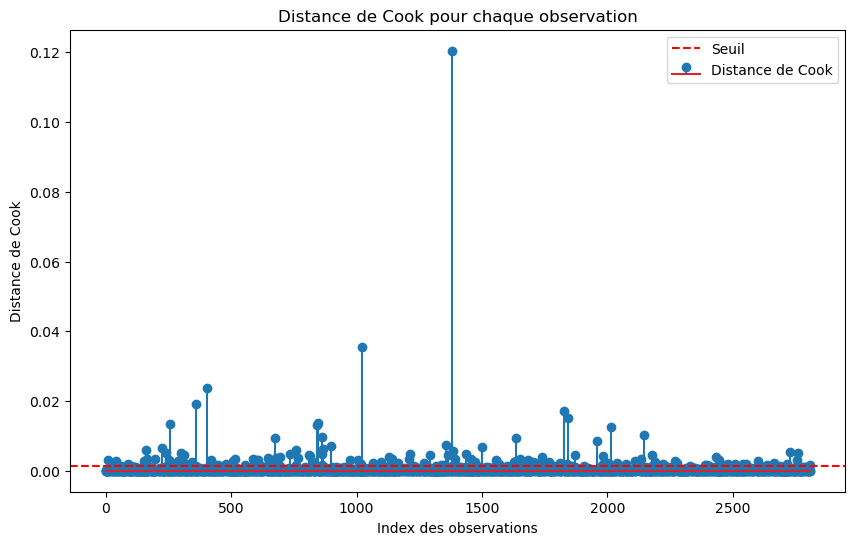

In [40]:
influence = model1.get_influence()

cooks_d, _ = influence.cooks_distance
print("Distances de Cook:", cooks_d)

threshold = 4 / len(X)
influential_points = cooks_d > threshold

print("Indices des points influents:", influential_points)

num_influential_points = sum(influential_points)
print(num_influential_points)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.stem(range(len(cooks_d)), cooks_d, markerfmt='o', label="Distance de Cook")
plt.axhline(y=threshold, color='r', linestyle='--', label="Seuil")
plt.xlabel("Index des observations")
plt.ylabel("Distance de Cook")
plt.title("Distance de Cook pour chaque observation")
plt.legend()
plt.show()

Nous allons effectuer un test de Breusch-Pagan pour détecter l’hétéroscédasticité potentielle.

In [21]:
test_breusch_pagan = sms.het_breuschpagan(model1.resid, model1.model.exog)

lm_stat, lm_p_value, f_stat, f_p_value = test_breusch_pagan

print("Statistique de Breusch-Pagan:", lm_stat)
print("P-valeur de Breusch-Pagan:", lm_p_value)
print("Statistique F:", f_stat)
print("P-valeur F:", f_p_value)

Statistique de Breusch-Pagan: 211.29830676412402
P-valeur de Breusch-Pagan: 2.1736619551051982e-32
Statistique F: 10.300930912594627
P-valeur F: 2.4532263630766452e-34


La p-value est très proche de 0 donc on peut rejeter l'hypothèse d’homoscédasticité. Essayons d'ajuster notre modèle à l'aide des erreurs standards robustes de type HC3.

In [22]:
model1_robust = sm.OLS(Y, X).fit(cov_type='HC3')

# Affichage des résultats avec erreurs robustes
print(model1_robust.summary())

                            OLS Regression Results                            
Dep. Variable:         log_nb_voy2022   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     4648.
Date:                Tue, 24 Dec 2024   Prob (F-statistic):               0.00
Time:                        15:22:55   Log-Likelihood:                -5934.5
No. Observations:                2808   AIC:                         1.191e+04
Df Residuals:                    2785   BIC:                         1.205e+04
Df Model:                          22                                         
Covariance Type:                  HC3                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [23]:
summary_corr_het_df = model1_robust.summary2().tables[1]
print(summary_corr_het_df)

                            Coef.  Std.Err.     z  P>|z|  [0.025  0.975]
const                        6.86      0.81  8.48   0.00    5.27    8.44
revmoy2022                  -0.00      0.00 -1.37   0.17   -0.00    0.00
pop2022                      0.00      0.00  3.86   0.00    0.00    0.00
psup2022                     0.02      0.01  2.19   0.03    0.00    0.04
pnodip2022                   0.01      0.01  1.29   0.20   -0.01    0.03
pcadr2022                    0.04      0.01  4.28   0.00    0.02    0.06
pouvr2022                    0.02      0.01  2.61   0.01    0.00    0.04
pchom2022                    0.05      0.01  4.07   0.00    0.02    0.07
pempl2022                    0.01      0.01  1.78   0.08   -0.00    0.03
pagri2022                   -0.07      0.01 -5.71   0.00   -0.09   -0.04
ppint2022                    0.01      0.01  1.62   0.10   -0.00    0.03
dist_closest_station_km      0.08      0.01  6.82   0.00    0.06    0.11
Auvergne-Rhône-Alpes         0.78      0.12  6.41  

Augmenter d'un point de pourcentage la proportion de cadre dans la commune augmente de 0.02% le nombre de voyageur dans une gare. Le coefficient ne peut pas être interprété comme un effect causal dû à l'endogénéité du modèle. La densité de population peut être perçue comme un biais de variable oubliée.  

# 3. Conclusion

Nous avons montrer qu'il existe un lien entre le pourcentage de catégories socio-professionnels et le nombre de voyageurs dans les communes. Cela ne suffit pas à en déduire un lien causal dû à l'endogénéité du modèle. Cela ne nous donne pas un modèle causal mais un modèle de prédiction. Il faudrait ajouter certaines variables comme les variables de densité de population ou de types de transports utilisés. 